In [1]:
# Appeding the path to the scaman package
import sys
sys.path.append('/Users/berke/Codes/scaman-2024/scaman') 
# flann path
sys.path.append('/Users/berke/Codes/python/flann/src/python')
import numpy as np

In [11]:
import time

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


# Load indianpines data
X = np.load('/Users/berke/Codes/scaman-2024/tests/data/indianpinearray.npy')
y = np.load('/Users/berke/Codes/scaman-2024/tests/data/IPgt.npy')



# Stratified sampling: 10% of the data
#X, _, y, _ = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

In [3]:
#reshape the data

X = np.reshape(X,(-1,X.shape[-1]))
y = np.reshape(y,(-1,))
print(X.shape)
print(y.shape)

(21025, 200)
(21025,)


In [4]:
# Step 2: Center data matrix
import numpy as np
means = np.mean(X, axis=0)
X_centered = X - means
# Step 3: Verify that covariance matrix is centered
assert np.allclose(np.mean(X_centered, axis=0), np.zeros_like(means))

In [5]:
# Step 4: Compute covariance matrix
cov = np.cov(X, rowvar=False)
eigs = np.linalg.eig(cov)[0]
eigs_sorted = np.flip(np.sort(eigs))
variances = np.cumsum(eigs_sorted)/np.sum(eigs_sorted)
tv = 0.8
actual_dim = np.argmax(np.array(variances)>tv)

In [7]:
from serial.pca import PCA

In [8]:
estDim=10

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
## Created test with estimated dimension and PCA
start_time_est_pca = time.time()
#X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=estDim,solver='slepc')
embedding_pca = pca.fit_transform(X)
end_time_est_pca = time.time()
#embedding shape
print(embedding_pca.shape)
#embedding type
print(type(embedding_pca))
print(f"Time taken: {end_time_est_pca - start_time_est_pca} seconds")

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 10
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 13

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 26796963.347433       7.72251e-16
 9206224.301748       1.22456e-15
 585421.803576       9.48315e-15
 321413.296959       6.92351e-15
 271910.619240       5.40736e-13
 202271.110606       2.29122e-11
 156368.149432       1.27803e-07
 141766.690473       9.59339e-13
 120158.052954         3.935e-11
 114713.863840       5.72282e-10
 104597.031348       1.19755e-09
 97506.783863       2.75452e-09
 87905.268312       1.13374e-07

(21025, 10)
<class 'numpy.ndarray'>
Time taken: 0.061190128326416016 seconds


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_pca, y, test_size=0.3, random_state=42)

# Fit the KNN model on the training data
start_time_est_knn = time.time()
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
end_time_est_knn = time.time()

# Use the trained model to predict the labels for the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of PCA applied data with estDim: {accuracy}")
print(f"Time taken: {end_time_est_knn - start_time_est_knn} seconds")

Accuracy of PCA applied data with estDim: 0.7079898541534559
Time taken: 0.006376981735229492 seconds


In [15]:
time_taken_intrinsic = 0.424 + (end_time_est_pca - start_time_est_pca) + (end_time_est_knn - start_time_est_knn)
print(f"Total time taken of ID+PCA+KNN: {time_taken_intrinsic} seconds")

Total time taken of ID+PCA+KNN: 0.4915671100616455 seconds


In [16]:
# Split the data into training and testing sets for original data
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, random_state=42)
start_time_org_knn = time.time()
# Fit the KNN model on the training data for original data
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_org, y_train_org)
end_time_org_knn = time.time()

# Use the trained model to predict the labels for the testing data for original data
y_pred_org = knn.predict(X_test_org)

# Calculate the accuracy of the model for original data
accuracy_org = accuracy_score(y_test_org, y_pred_org)
print(f"Accuracy of original dataset: {accuracy_org}")
print(f"Time taken: {end_time_org_knn - start_time_org_knn} seconds")

Accuracy of original dataset: 0.7234244946492271
Time taken: 0.0012700557708740234 seconds


In [17]:

# Initialize an empty list to store the accuracies and times
accuracies = []
times = []

# Define the range of dimensions
dimensions = range(2, 50, 2)

# Loop through each dimension
for dim in dimensions:
    start_time = time.time()
    
    # Perform PCA with the current dimension
    pca = PCA(n_components=dim,solver='slepc')
    embedding_pca = pca.fit_transform(X)
    embedding_pca = np.real(embedding_pca)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(embedding_pca, y, test_size=0.2, random_state=42)
    
    # Fit the KNN model on the training data
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, y_train)
    
    # Use the trained model to predict the labels for the testing data
    y_pred = knn.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)
    
    end_time = time.time()
    times.append(end_time - start_time)

# Print the accuracies and times for each dimension
for dim, accuracy, time_taken in zip(dimensions, accuracies, times):
    print(f"Dimension: {dim}, Accuracy: {accuracy}, Time taken: {time_taken} seconds")

print(accuracies)
print(times)

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 2
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 4

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 26796963.347433       7.20841e-16
 9206224.301748       1.31374e-15
 585421.803576       6.39702e-14
 321413.296959       5.95436e-08

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 4
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 5

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 26796963.347433       7.07684e-16
 9206224.301748       1.20872e-15
 585421.803576       8.16268e-15
 32141

In [19]:
time_taken_loop = np.sum(times)
print(f"Total time taken for loop: {np.sum(times)} seconds")

Total time taken for loop: 3.273855686187744 seconds


In [20]:
# Create lists of dimensions and accuracies
dimensions = list(range(2, 50, 2))



In [ ]:
dimensions.append(estDim)
accuracies.append(accuracy)

/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_33434/3800796389.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Dimensions')


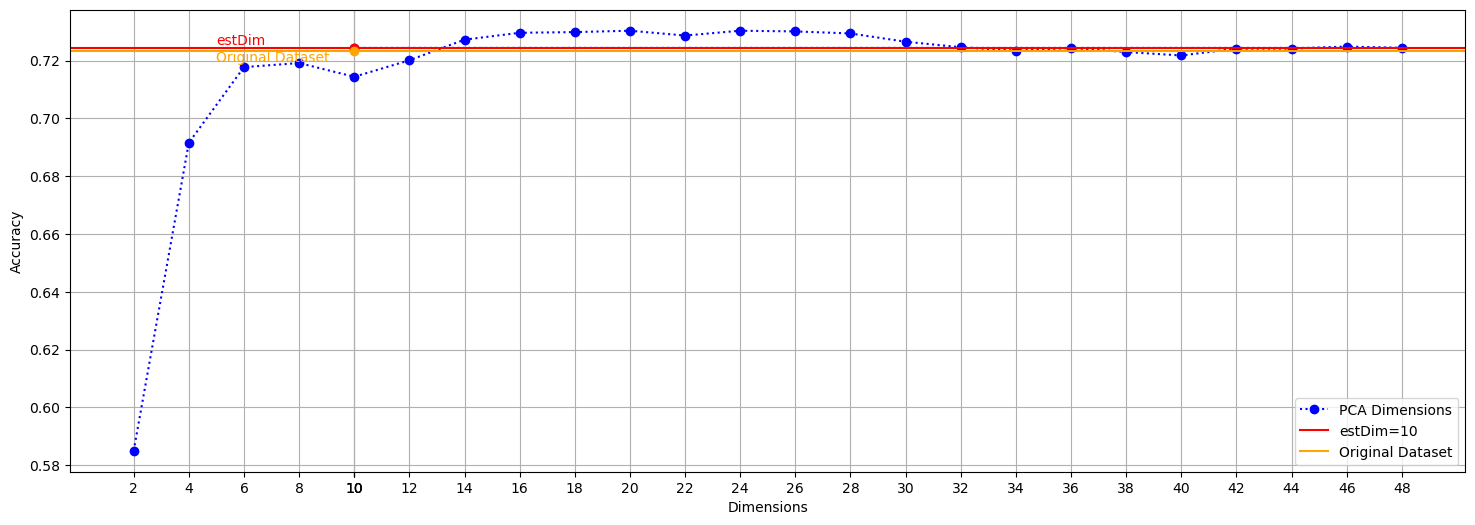

In [23]:
import matplotlib.pyplot as plt


#accuracies.append(accuracy)

# Set the size of the plot
plt.figure(figsize=(18, 6))  # Width: 18 inches, Height: 6 inches

# Create a blue dotted line plot of dimensions vs accuracies with markers
plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Dimensions')

# Highlight the accuracy of estDim with a straight red line
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'estDim={estDim}')
plt.text(5, accuracy, 'estDim', verticalalignment='bottom', color='red')

# Plot the accuracy of the original data with a straight orange line
plt.axhline(y=accuracy_org, color='orange', linestyle='-', label='Original Dataset')
plt.text(5, accuracy_org, 'Original Dataset', verticalalignment='top', color='orange')

# Highlight the intersection point at estimated dimension
# Plot these after the blue line to ensure they appear on top
plt.scatter(estDim, accuracy, color='red', zorder=5)
plt.scatter(estDim, accuracy_org, color='orange', zorder=5)

# Add grid
plt.grid(True)

# Set x-axis to show all dimensions
plt.xticks(dimensions + [estDim])

# Label the axes and create a legend
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
#plt.title('Indian Pines - PCA and kNN Accuracies with Dimension Estimator')
plt.legend()

plt.show()

/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_33434/2397818329.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Dimensions')
/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_33434/2397818329.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


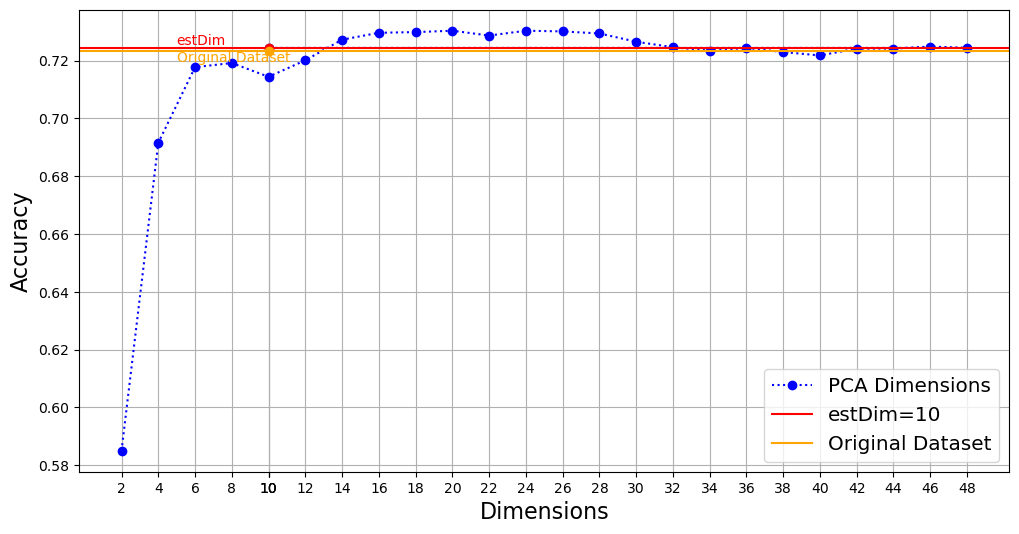

In [26]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(12, 6))  # Width: 18 inches, Height: 6 inches

# Create a blue dotted line plot of dimensions vs accuracies with markers
plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Dimensions')

# Highlight the accuracy of estDim with a straight red line
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'estDim={estDim}')
plt.text(5, accuracy, 'estDim', verticalalignment='bottom', color='red')

# Plot the accuracy of the original data with a straight orange line
plt.axhline(y=accuracy_org, color='orange', linestyle='-', label='Original Dataset')
plt.text(5, accuracy_org, 'Original Dataset', verticalalignment='top', color='orange')

# Highlight the intersection point at estimated dimension
# Plot these after the blue line to ensure they appear on top
plt.scatter(estDim, accuracy, color='red', zorder=5)
plt.scatter(estDim, accuracy_org, color='orange', zorder=5)

# Add grid
plt.grid(True)

# Set x-axis to show all dimensions
plt.xticks(dimensions + [estDim])

# Label the axes and create a legend
plt.xlabel('Dimensions', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
#plt.title('Indian Pines - PCA and kNN Accuracies with Dimension Estimator', fontsize=16)

# Create a legend with larger font size
legend = plt.legend(fontsize='x-large')

# Increase the size of the legend markers
for handle in legend.legendHandles:
    handle._sizes = [85]

plt.show()